In [1]:
#alll libraries i need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from sklearn.metrics import accuracy_score ,classification_report ,roc_curve, auc ,precision_recall_curve
from tensorflow.keras import layers

In [2]:
# Define paths
train_folder = "/kaggle/input/egyptian-hieroglyphs/train/"
valid_folder = "/kaggle/input/egyptian-hieroglyphs/valid/"
test_folder = "/kaggle/input/egyptian-hieroglyphs/test/"

# Load CSV files
train_data_df = pd.read_csv("/kaggle/input/egyptian-hieroglyphs/train/_annotations.csv")
valid_data_df = pd.read_csv("/kaggle/input/egyptian-hieroglyphs/valid/_annotations.csv")
test_data_df = pd.read_csv("/kaggle/input/egyptian-hieroglyphs/test/_annotations.csv")
train_data_df

filename  width  height  \
0     nile-fish-7-_jpg.rf.31e4278980878c47a1e6a2f8dd...    640     640   
1     Her-8-_jpg.rf.32bcf63f4ae4d6aea53cea5b9c0059b4...    640     640   
2     composite_bow-34-_jpg.rf.33153e63f7158777c50d4...    640     640   
3     snake-6-_jpg.rf.32ac52ece4bcc06b1ead936693df17...    640     640   
4     king-26-_jpg.rf.329a5a8e366f4fe2e3a3dca88524cc...    640     640   
...                                                 ...    ...     ...   
2718  limits-3-_jpg.rf.fe51052a18bcf65204ef3da4147d1...    640     640   
2719  swallow-17-_jpg.rf.ff6d9c69bffa365d5dc7ff9dddb...    640     640   
2720  nursing-21-_jpg.rf.ff1a56a1ffcf9f41bf451e14c5c...    640     640   
2721  this-40-_jpg.rf.ffbb60d2c4951789b9e0b84b7ec2d0...    640     640   
2722  owl-15-_jpg.rf.ff30cfa7a5fa91b3a07371780b6ffdc...    640     640   

              class  xmin  ymin  xmax  ymax  
0         Nile_Fish   375   319   512   454  
1               Her   211   247   368   339  
2     Composite_Bow   158   183   336   282  
3             Snake   181   351   318   506  
4              King   218   290   339   524  
...             ...   ...   ...   ...   ...  
2718          Limit   356   339   471   498  
2719        Swallow   350   339   524   445  
2720        Nursing   320   217   416   367  
2721           This   150   213   283   367  
2722            Owl   239   135   364   269  

[2723 rows x 8 columns]

In [3]:
#check number of classes
no_class_tr = train_data_df['class'].nunique()
no_class_val = train_data_df['class'].nunique()
no_class_tes = train_data_df['class'].nunique()
print('train: ',no_class_tr,'valid: ',no_class_val,'test: ',no_class_tes)

train:  95 valid:  95 test:  95


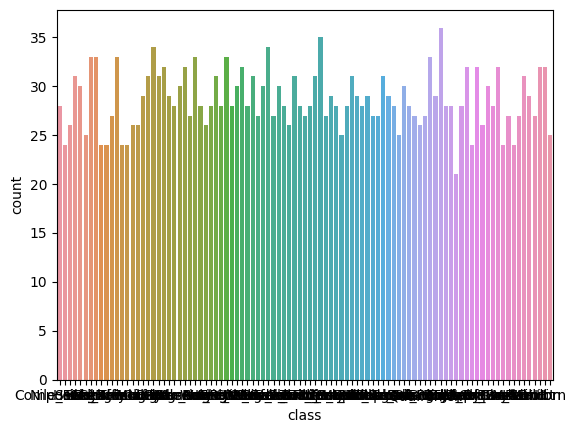

In [4]:
sns.countplot(data=train_data_df,x=train_data_df['class'])
plt.show()

In [5]:
# Get the value counts for the 'class' column
class_counts = train_data_df['class'].value_counts()


# Find the class with the minimum count
min_class = class_counts.idxmin()
min_count = class_counts.min()

# Find the class with the maximum count
max_class = class_counts.idxmax()
max_count = class_counts.max()

print(f"Class with minimum count: {min_class} (Count: {min_count})")
print(f"Class with maximum count: {max_class} (Count: {max_count})")


Class with minimum count: One (Count: 21)
Class with maximum count: Book (Count: 36)


In [6]:
def load_and_crop_images(data_df, folder_path):
    cropped_images = []
    labels = []
    
    for index, row in data_df.iterrows():
        # Construct the full image path
        img_path = os.path.join(folder_path, row['filename'])
        
        # Read the image
        img = cv2.imread(img_path)
        
        # Check if image is read correctly
        if img is not None:
            # Get bounding box coordinates
            xmin, ymin, xmax, ymax = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
            
            # Crop the image using bounding box
            cropped_img = img[ymin:ymax, xmin:xmax]
            
            # Store the cropped image and label
            cropped_images.append(cropped_img)
            labels.append(row['class'])
        else:
            print(f"Image {img_path} not found.")
    
    return cropped_images, labels



In [7]:
train_images, train_labels = load_and_crop_images(train_data_df, train_folder)
valid_images, valid_labels = load_and_crop_images(valid_data_df, valid_folder)
test_images, test_labels = load_and_crop_images(test_data_df, test_folder)


In [8]:
def preprocess_images(images, target_size=(224, 224)):
    preprocessed_images = []
    
    for img in images:
        # Resize the image to target size
        resized_img = cv2.resize(img, target_size)
        
        # Convert BGR to RGB (OpenCV reads images in BGR format)
        rgb_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
        
        # Rescale the image to range [0, 1] and convert to uint8
        scaled_img = (rgb_img / 255.0)  # Scale to [0, 1]
        scaled_img_uint8 = (scaled_img * 255).astype(np.uint8)  # Convert to [0, 255] and uint8
        
        # Store the preprocessed image
        preprocessed_images.append(scaled_img_uint8)
    
    return preprocessed_images


In [9]:
train_preprocessed_images = preprocess_images(train_images)
valid_preprocessed_images = preprocess_images(valid_images)
test_preprocessed_images = preprocess_images(test_images)


In [10]:
def display_images(images, labels, num_images=9):
    
    num_images = min(num_images, len(images), len(labels))
    random_indices = np.random.choice(len(images), num_images, replace=False)
    
    plt.figure(figsize=(15, 15))
    for i, idx in enumerate(random_indices):
        plt.subplot(3, 3, i + 1)  # Create a 3x3 grid
        plt.imshow(images[idx])  # Display the randomly selected image
        plt.title(labels[idx])  # Set the title to the corresponding label
        plt.axis('off')  # Hide axes
    plt.show()

In [11]:
print("Data type of first image:", train_preprocessed_images[0].dtype)
print("Shape of first image:", train_preprocessed_images[0].shape)


Data type of first image: uint8
Shape of first image: (224, 224, 3)


--------------------------------------Train Sample------------------------------


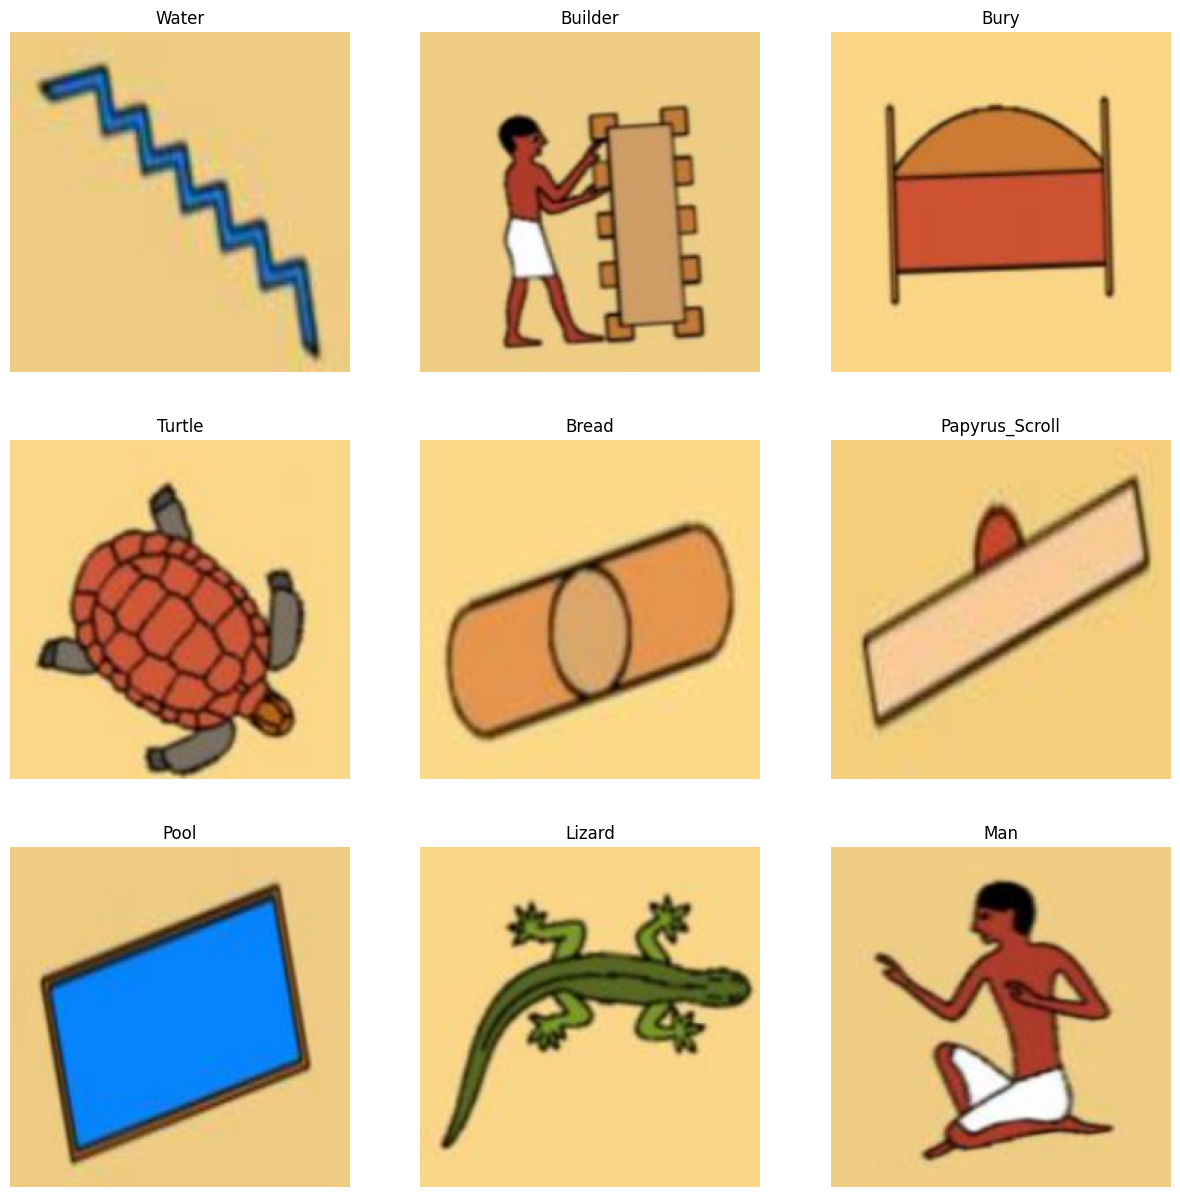

In [12]:
# Assuming you have corresponding labels for your training images
train_labels = train_data_df['class'].tolist()  # Adjust this based on your labels

print('--------------------------------------Train Sample------------------------------')
# Display the first 9 preprocessed images with labels
display_images(train_preprocessed_images, train_labels)


In [13]:
print(f'Number of validation images: {len(valid_preprocessed_images)}')
print(f'Number of validation labels: {len(valid_labels)}')

Number of validation images: 778
Number of validation labels: 778


--------------------------------------Valid Sample------------------------------


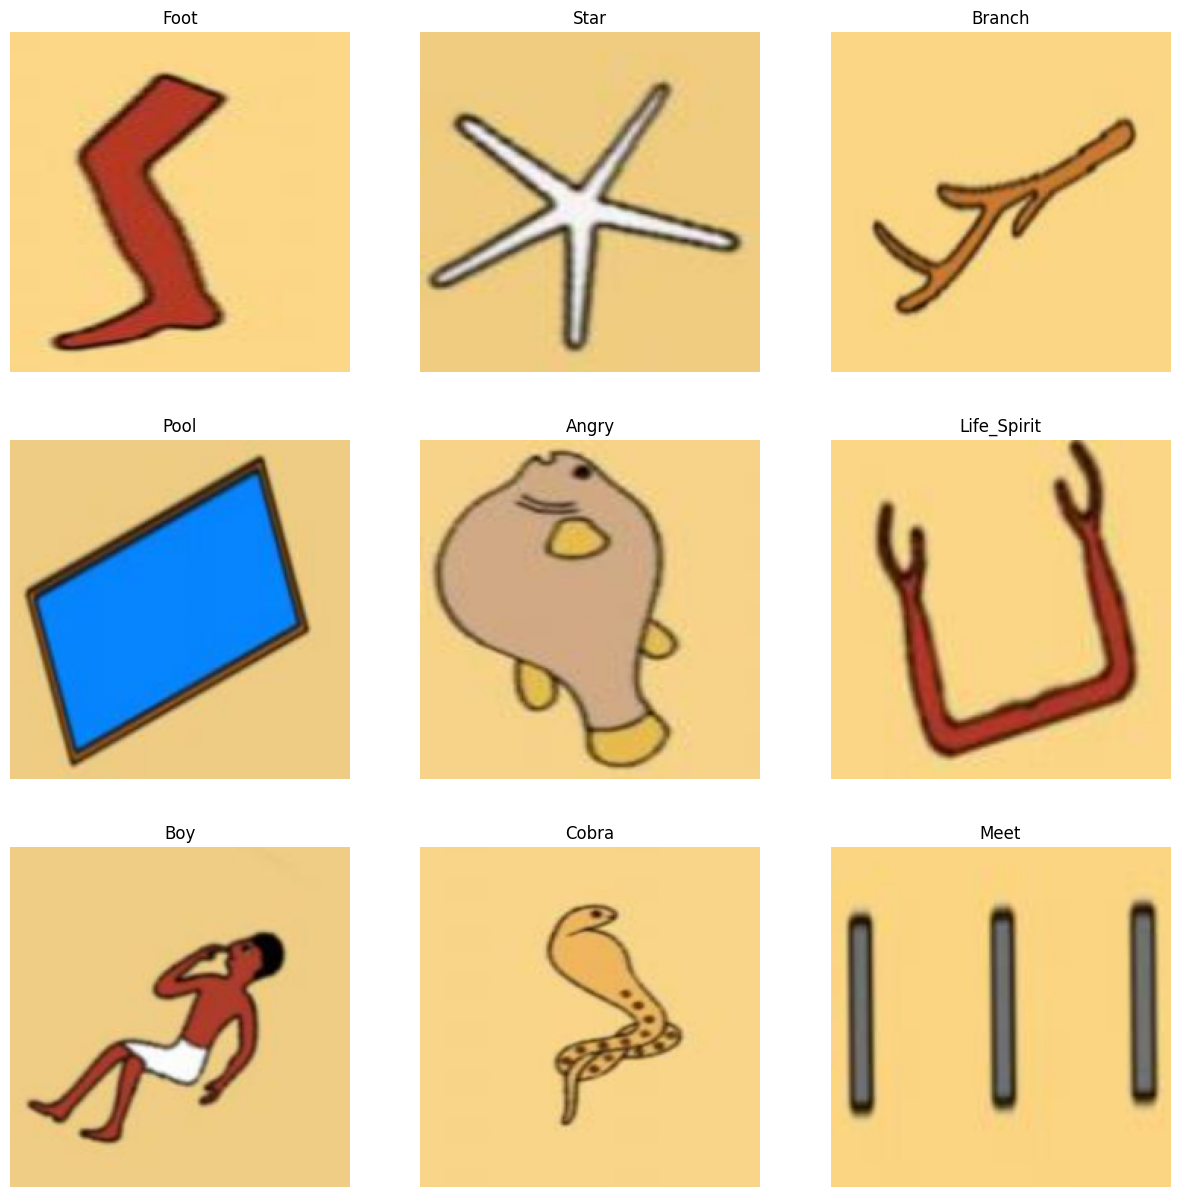

In [14]:
# Assuming you have corresponding labels for your training images
valid_labels = valid_data_df['class'].tolist()  # Adjust this based on your labels

print('--------------------------------------Valid Sample------------------------------')
# Display the first 9 preprocessed images with labels
display_images(valid_preprocessed_images, valid_labels)


--------------------------------------Test Sample------------------------------


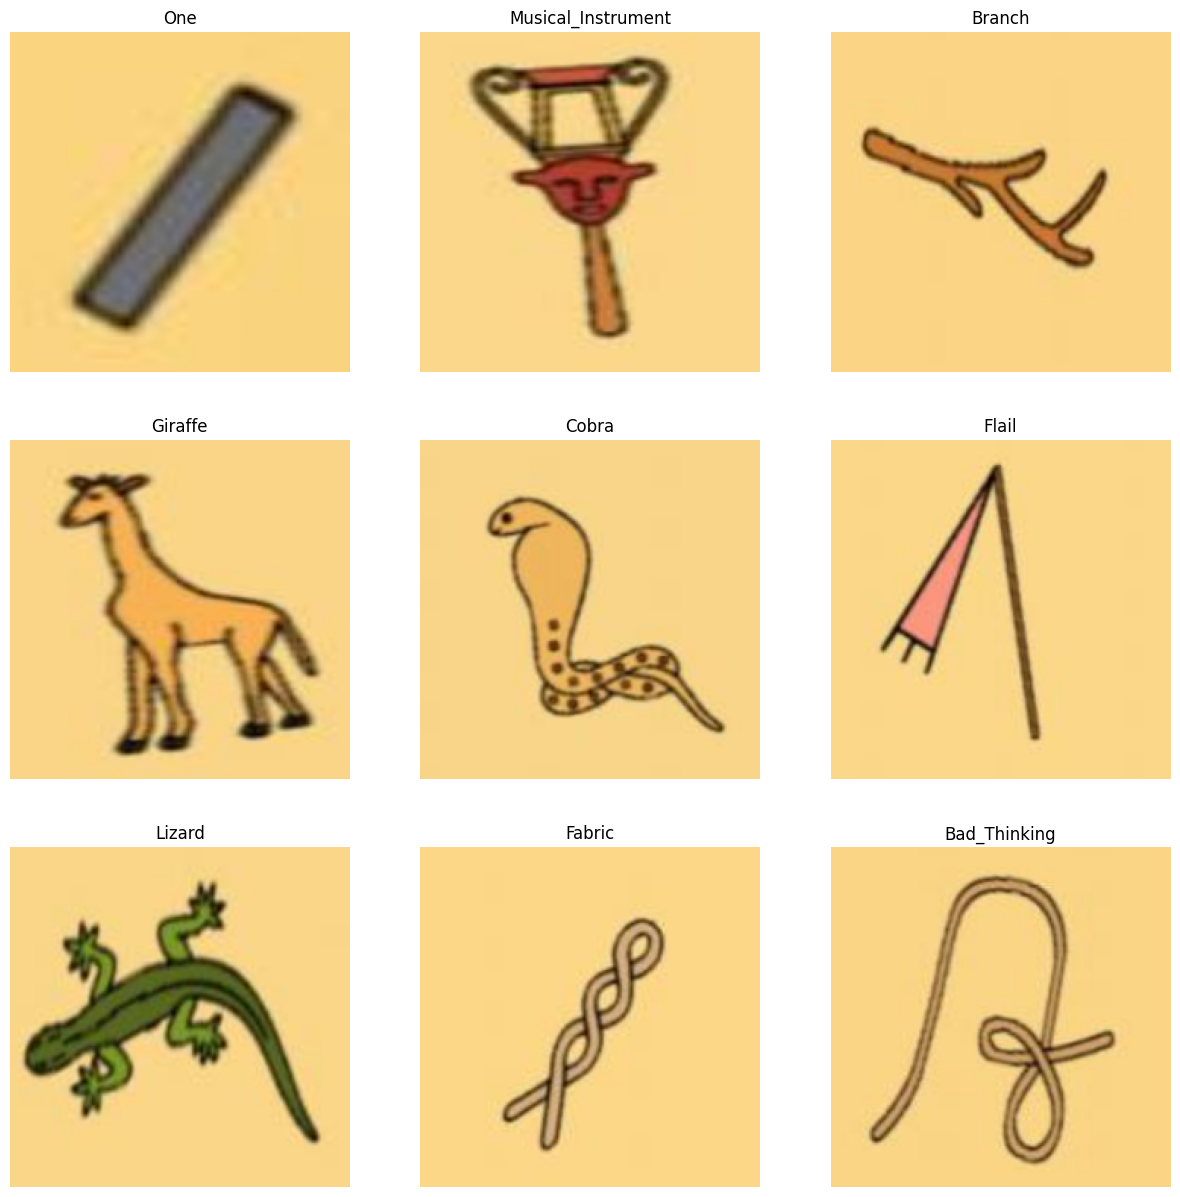

In [15]:
# Assuming you have corresponding labels for your training images
test_labels = test_data_df['class'].tolist()  # Adjust this based on your labels

print('--------------------------------------Test Sample------------------------------')
# Display the first 9 preprocessed images with labels
display_images(test_preprocessed_images, test_labels)


In [16]:
train_images = np.array(train_preprocessed_images)
valid_images = np.array(valid_preprocessed_images)
test_images = np.array(test_preprocessed_images)



# Convert to NumPy array
train_labels = np.array(train_labels)
valid_labels = np.array(valid_labels)
test_labels = np.array(test_labels)
train_images.shape
#train_images = train_preprocessed_images.reshape()

(2723, 224, 224, 3)

In [17]:
NEW_SIZE = 224
train_images = train_images.reshape(train_images.shape[0], NEW_SIZE, NEW_SIZE, 3)
valid_images = valid_images.reshape(valid_images.shape[0], NEW_SIZE, NEW_SIZE, 3)
test_images = test_images.reshape(test_images.shape[0], NEW_SIZE, NEW_SIZE, 3)

In [18]:
train_images.shape

(2723, 224, 224, 3)

In [19]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(train_images)

In [20]:
print(f'Number of validation images: {len(train_preprocessed_images)}')
print(f'Number of validation labels: {len(train_labels)}')

Number of validation images: 2723
Number of validation labels: 2723


In [21]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels = to_categorical(label_encoder.fit_transform(train_labels))
valid_labels  = to_categorical(label_encoder.transform(valid_labels))
test_labels = to_categorical(label_encoder.transform(test_labels))

# CNN Model

In [22]:
'''num_classes = len(df_train['class'].unique())  # Ensure you're using the training DataFrame
input_shape = (224, 224, 3)

# Build the model
model = Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))'''

"num_classes = len(df_train['class'].unique())  # Ensure you're using the training DataFrame\ninput_shape = (224, 224, 3)\n\n# Build the model\nmodel = Sequential()\nmodel.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))\nmodel.add(layers.MaxPooling2D(pool_size=(2, 2)))\n\nmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))\nmodel.add(layers.MaxPooling2D(pool_size=(2, 2)))\n\nmodel.add(layers.Conv2D(128, (3, 3), activation='relu'))\nmodel.add(layers.MaxPooling2D(pool_size=(2, 2)))\n\nmodel.add(layers.Conv2D(256, (3, 3), activation='relu'))\nmodel.add(layers.MaxPooling2D(pool_size=(2, 2)))\n\nmodel.add(layers.Flatten())\nmodel.add(layers.Dense(256, activation='relu'))\nmodel.add(layers.Dropout(0.5))\nmodel.add(layers.Dense(num_classes, activation='softmax'))"

In [23]:
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from tensorflow import keras

# Image size and number of classes
img_size = (224, 224, 3)
no_class_tr = 95


# Creating the model using the Sequential API
def create_simple_cnn(input_shape):
    model = keras.models.Sequential()
    # First Conv Layer with regularization
    model.add(keras.layers.Conv2D(128, kernel_size=4, padding="same", activation="relu", 
                                  kernel_initializer="he_normal", 
                                  input_shape=input_shape))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D(pool_size=2))
    # Second Conv Layer with Batch Normalization
    model.add(keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu", 
                                  kernel_initializer="he_normal"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D(pool_size=2))
    
    # Third Conv Layer
    model.add(keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu", 
                                  kernel_initializer="he_normal"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D(pool_size=2))
    

    # Fourth Conv Layer
    model.add(keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu", 
                                  kernel_initializer="he_normal" ))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D(pool_size=2))

    # Increased Dropout
    model.add(keras.layers.Dropout(0.3))

    # Flattening the output for Dense layers
    model.add(keras.layers.Flatten())

    # Fully connected layers
    model.add(keras.layers.Dense(128, kernel_initializer='he_normal', activation='relu'))
    model.add(keras.layers.Dense(64, kernel_initializer='he_normal', activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    # Output layer
    model.add(keras.layers.Dense(no_class_tr, activation="softmax"))

    return model

In [24]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, min_delta=0.01)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

callbacks = [early_stopping, model_checkpoint]
metrics=['accuracy', 'precision', 'recall']
# Create the model


In [25]:
cnn_model = create_simple_cnn(img_size)

# Compile the model with a reduced learning rate
cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=metrics)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 128)  │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 95)             │         6,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 926,175 (3.53 MB)

 Trainable params: 925,663 (3.53 MB)

 Non-trainable params: 512 (2.00 KB)

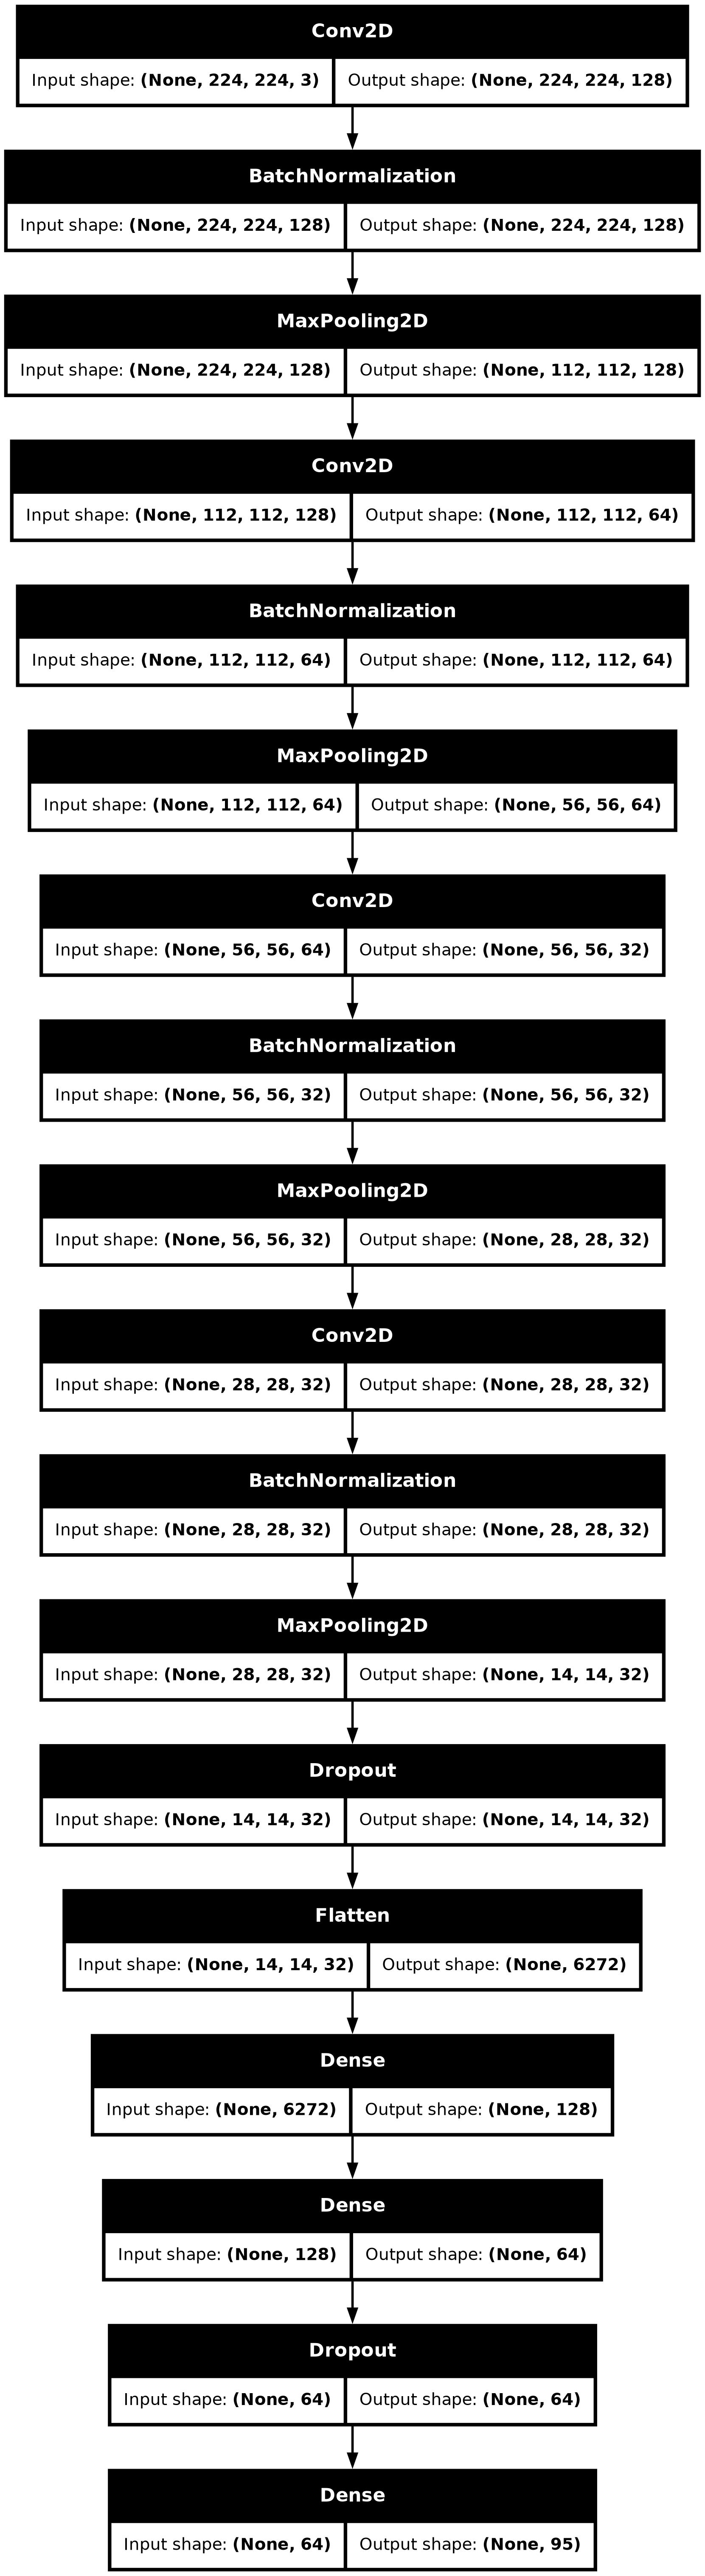

In [27]:
# Plot the model
from tensorflow.keras.utils import plot_model
plot_model(cnn_model, show_shapes=True)

In [28]:
history = cnn_model.fit(
    train_images,train_labels,
    epochs=100,
    batch_size=64,
    validation_data=(valid_images,valid_labels),
    validation_batch_size=64,
    callbacks=callbacks
)

Epoch 1/100


I0000 00:00:1729937018.718029     109 service.cc:145] XLA service 0x7fdbc4004fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729937018.718089     109 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729937018.718093     109 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1729937037.438831     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


43/43 ━━━━━━━━━━━━━━━━━━━━ 46s 569ms/step - accuracy: 0.0397 - loss: 4.6571 - precision: 0.3440 - recall: 0.0051 - val_accuracy: 0.0360 - val_loss: 16.9981 - val_precision: 0.0371 - val_recall: 0.0334
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 217ms/step - accuracy: 0.2636 - loss: 3.0581 - precision: 0.8491 - recall: 0.1055 - val_accuracy: 0.0463 - val_loss: 25.9311 - val_precision: 0.0474 - val_recall: 0.0463
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 218ms/step - accuracy: 0.5793 - loss: 1.5821 - precision: 0.8626 - recall: 0.4121 - val_accuracy: 0.0437 - val_loss: 39.8293 - val_precision: 0.0446 - val_recall: 0.0437
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 221ms/step - accuracy: 0.7810 - loss: 0.7860 - precision: 0.8871 - recall: 0.6725 - val_accuracy: 0.0964 - val_loss: 16.5653 - val_precision: 0.1047 - val_recall: 0.0964
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 222ms/step - accuracy: 0.8600 - loss: 0.4551 - precision: 0.9160 - recall: 0.7926 - val_accuracy: 0.2069 - val_loss: 10

In [29]:
#plotting training values
import seaborn as sns
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

precision = history.history['precision']
val_precision = history.history['val_precision']

recall =history.history['recall']
val_recall =history.history['val_recall']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

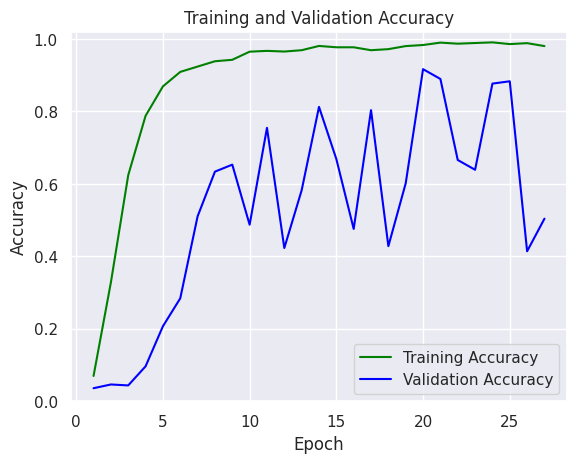

In [30]:
#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim(0,1.02)
plt.show()

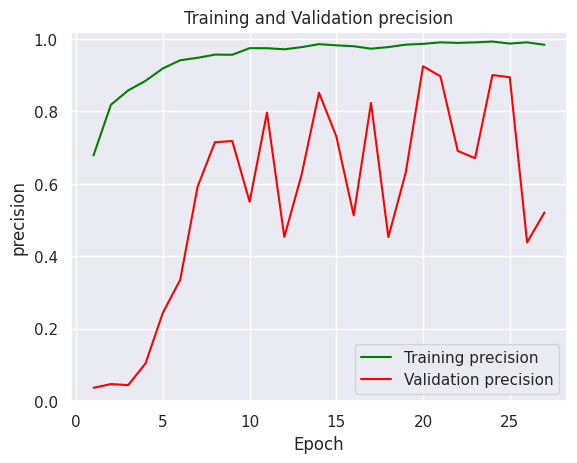

In [31]:
plt.figure()
#precision plot
plt.plot(epochs, precision, color='green', label='Training precision')
plt.plot(epochs, val_precision, color='red', label='Validation precision')
plt.title('Training and Validation precision')
plt.xlabel('Epoch')
plt.ylabel('precision')
plt.legend()
plt.ylim(0,1.02)
plt.show()

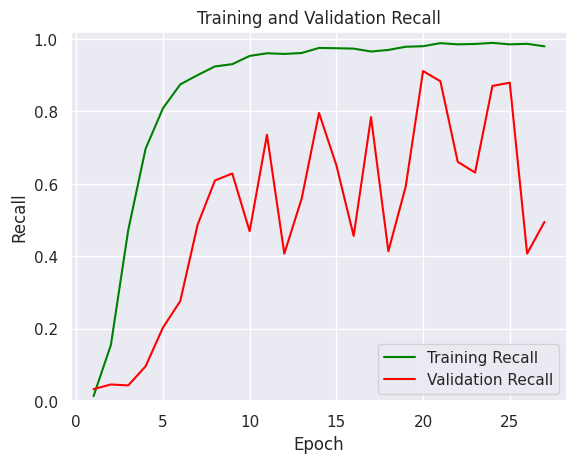

In [32]:
plt.figure()
#loss plot
plt.plot(epochs, recall, color='green', label='Training Recall')
plt.plot(epochs, val_recall, color='red', label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.ylim(0,1.02)
plt.show()

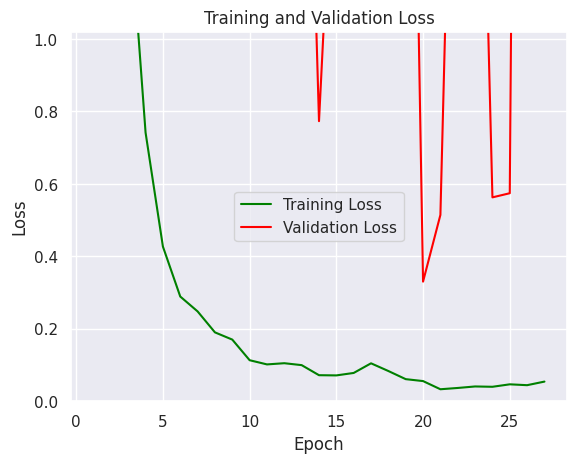

In [33]:
plt.figure()
#loss plot
plt.plot(epochs, loss, color='green', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0,1.02)
plt.show()

In [34]:
def evaluate_model(model, train_gen, valid_gen, test_gen):
    # Evaluate the model on the training data generator
    model_eval_train = model.evaluate(train_gen)
    print('Training Data:')
    print('Loss:      ', model_eval_train[0])
    print('Accuracy:  ', model_eval_train[1])
    print('Precision: ', model_eval_train[2])
    print('Recall:    ', model_eval_train[3])
    
    # Evaluate the model on the validation data generator
    model_eval_valid = model.evaluate(valid_gen)
    print('\nValidation Data:')
    print('Loss:      ', model_eval_valid[0])
    print('Accuracy:  ', model_eval_valid[1])
    print('Precision: ', model_eval_valid[2])
    print('Recall:    ', model_eval_valid[3])
    
    # Evaluate the model on the test data generator
    model_eval_test = model.evaluate(test_gen)
    print('\nTest Data:')
    print('Loss:      ', model_eval_test[0])
    print('Accuracy:  ', model_eval_test[1])
    print('Precision: ', model_eval_test[2])
    print('Recall:    ', model_eval_test[3])
    
    return (np.round(model_eval_train[0], 2), np.round(model_eval_valid[0], 2), np.round(model_eval_test[0], 2),
            np.round(model_eval_train[1], 2), np.round(model_eval_valid[1], 2), np.round(model_eval_test[1], 2),
            np.round(model_eval_train[2], 2), np.round(model_eval_valid[2], 2), np.round(model_eval_test[2], 2),
            np.round(model_eval_train[3], 2), np.round(model_eval_valid[3], 2), np.round(model_eval_test[3], 2) )


In [35]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_images, valid_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(32).prefetch(tf.data.AUTOTUNE)



In [36]:
evaluate_model(cnn_model, train_dataset, valid_dataset, test_dataset)

86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.9887 - loss: 0.0316 - precision: 0.9886 - recall: 0.9872
Training Data:
Loss:       0.035775162279605865
Accuracy:   0.9886155128479004
Precision:  0.9886029362678528
Recall:     0.9875137805938721
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9037 - loss: 0.3559 - precision: 0.9120 - recall: 0.8991

Validation Data:
Loss:       0.3301672339439392
Accuracy:   0.9164524674415588
Precision:  0.9243807196617126
Recall:     0.9113110303878784
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.9308 - loss: 0.2360 - precision: 0.9432 - recall: 0.9300

Test Data:
Loss:       0.2682959735393524
Accuracy:   0.9280205368995667
Precision:  0.939947783946991
Recall:     0.9254498481750488


(0.04, 0.33, 0.27, 0.99, 0.92, 0.93, 0.99, 0.92, 0.94, 0.99, 0.91, 0.93)

In [37]:
Final_report = []

In [38]:
Final_report.append(evaluate_model(cnn_model, train_dataset, valid_dataset, test_dataset))

86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9887 - loss: 0.0316 - precision: 0.9886 - recall: 0.9872
Training Data:
Loss:       0.035775162279605865
Accuracy:   0.9886155128479004
Precision:  0.9886029362678528
Recall:     0.9875137805938721
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9037 - loss: 0.3559 - precision: 0.9120 - recall: 0.8991

Validation Data:
Loss:       0.3301672339439392
Accuracy:   0.9164524674415588
Precision:  0.9243807196617126
Recall:     0.9113110303878784
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9308 - loss: 0.2360 - precision: 0.9432 - recall: 0.9300

Test Data:
Loss:       0.2682959735393524
Accuracy:   0.9280205368995667
Precision:  0.939947783946991
Recall:     0.9254498481750488


In [39]:
cnn_model.save('cnn_model.h5')

# Transfer Learning

In [40]:
models = { 
"VGG19": tf.keras.applications.VGG19,

"DenseNet169": tf.keras.applications.DenseNet169,
    
"DenseNet121": tf.keras.applications.DenseNet121,
    
"MobileNetV2": tf.keras.applications.MobileNetV2,

"EfficientNetB7": tf.keras.applications.EfficientNetB7,
    
"ResNet50": tf.keras.applications.ResNet50,

"NASNetMobile": tf.keras.applications.NASNetMobile,
}

## VGG19

In [41]:
input_shape = (224, 224, 3)  
# Define inputs
inputs = tf.keras.Input(shape=input_shape)
print(inputs)
model_name='VGG19'
base_model = models[model_name](include_top=False, weights='imagenet', input_tensor=inputs)

<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=None, name=keras_tensor_172>
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [42]:
def VGG19(base_model, inputs):
    # Freeze the base model layers
    base_model.trainable = False

    x = tf.keras.layers.Flatten()(base_model.output)

    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(95, activation='softmax')(x)

    # Create model
    model = tf.keras.models.Model(inputs = inputs, outputs = outputs)
    return model

In [43]:
vgg_model = VGG19(base_model, inputs)
vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics= metrics)

In [44]:
vgg_model.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,179,615 (76.98 MB)

 Trainable params: 154,591 (603.87 KB)

 Non-trainable params: 20,025,024 (76.39 MB)

In [45]:
history = vgg_model.fit(
    train_images,train_labels,
    epochs=30,
    batch_size=64,
    validation_data=(valid_images,valid_labels),
    validation_batch_size=64,
    callbacks=callbacks
)

Epoch 1/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.0444 - loss: 4.6773 - precision: 0.2177 - recall: 0.0019 - val_accuracy: 0.3959 - val_loss: 2.5363 - val_precision: 0.8938 - val_recall: 0.1298
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 385ms/step - accuracy: 0.3195 - loss: 2.9675 - precision: 0.8977 - recall: 0.0371 - val_accuracy: 0.8201 - val_loss: 1.4933 - val_precision: 0.9602 - val_recall: 0.2789
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 388ms/step - accuracy: 0.5755 - loss: 2.1654 - precision: 0.9309 - recall: 0.1108 - val_accuracy: 0.9332 - val_loss: 0.9925 - val_precision: 0.9892 - val_recall: 0.4730
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 388ms/step - accuracy: 0.7219 - loss: 1.6556 - precision: 0.9665 - recall: 0.2194 - val_accuracy: 0.9679 - val_loss: 0.6995 - val_precision: 0.9935 - val_recall: 0.5913
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 387ms/step - accuracy: 0.8133 - loss: 1.2696 - precision: 0.9722 - recall: 0.3250 - val_accuracy: 0.9653 - val_loss: 

In [46]:
#plotting training values
import seaborn as sns
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

precision = history.history['precision']
val_precision = history.history['val_precision']

recall =history.history['recall']
val_recall =history.history['val_recall']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

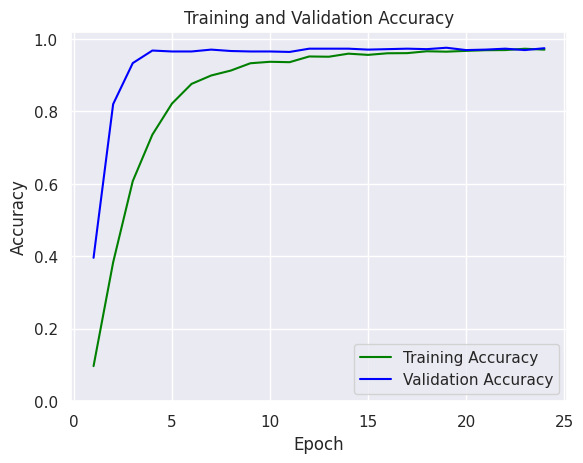

In [47]:
#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim(0,1.02)
plt.show()

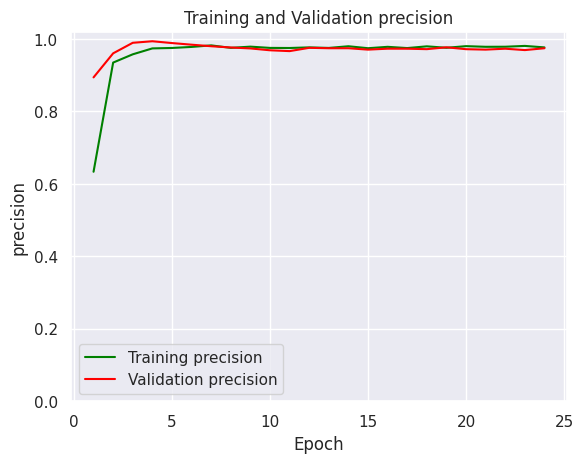

In [48]:
plt.figure()
#precision plot
plt.plot(epochs, precision, color='green', label='Training precision')
plt.plot(epochs, val_precision, color='red', label='Validation precision')
plt.title('Training and Validation precision')
plt.xlabel('Epoch')
plt.ylabel('precision')
plt.legend()
plt.ylim(0,1.02)
plt.show()

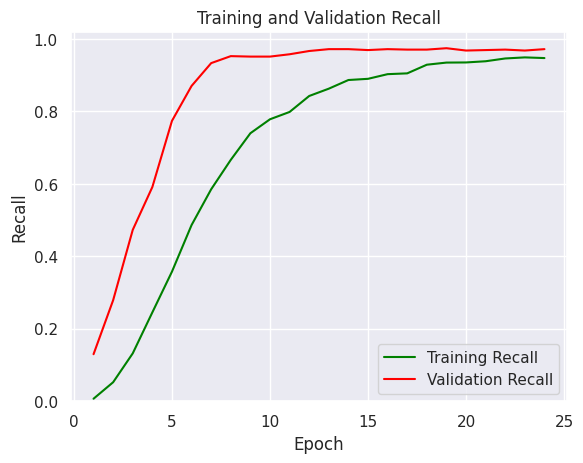

In [49]:
plt.figure()
#Recall plot
plt.plot(epochs, recall, color='green', label='Training Recall')
plt.plot(epochs, val_recall, color='red', label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.ylim(0,1.02)
plt.show()

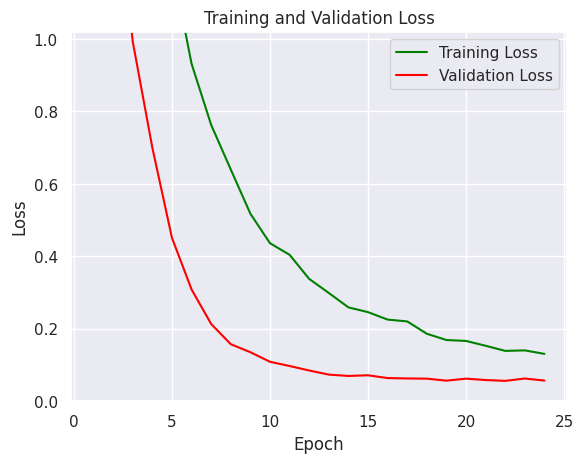

In [50]:
plt.figure()
#loss plot
plt.plot(epochs, loss, color='green', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0,1.02)
plt.show()

In [52]:
#evaluate model
evaluate_model(vgg_model, train_dataset, valid_dataset, test_dataset)

86/86 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 0.9831 - loss: 0.0443 - precision: 0.9833 - recall: 0.9818
Training Data:
Loss:       0.04047903046011925
Accuracy:   0.9849430918693542
Precision:  0.9852941036224365
Recall:     0.9842085838317871
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - accuracy: 0.9772 - loss: 0.0635 - precision: 0.9771 - recall: 0.9718

Validation Data:
Loss:       0.06289881467819214
Accuracy:   0.9730077385902405
Precision:  0.9729381203651428
Recall:     0.9704369902610779
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 506ms/step - accuracy: 0.9751 - loss: 0.0600 - precision: 0.9751 - recall: 0.9751

Test Data:
Loss:       0.05502886325120926
Accuracy:   0.9768637418746948
Precision:  0.9768637418746948
Recall:     0.9768637418746948


(0.04, 0.06, 0.06, 0.98, 0.97, 0.98, 0.99, 0.97, 0.98, 0.98, 0.97, 0.98)

In [53]:
vgg_model.save('vgg_model.h5')

In [54]:
Final_report.append(evaluate_model(vgg_model, train_dataset, valid_dataset, test_dataset))

86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 160ms/step - accuracy: 0.9831 - loss: 0.0443 - precision: 0.9833 - recall: 0.9818
Training Data:
Loss:       0.04047903046011925
Accuracy:   0.9849430918693542
Precision:  0.9852941036224365
Recall:     0.9842085838317871
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - accuracy: 0.9772 - loss: 0.0635 - precision: 0.9771 - recall: 0.9718

Validation Data:
Loss:       0.06289881467819214
Accuracy:   0.9730077385902405
Precision:  0.9729381203651428
Recall:     0.9704369902610779
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.9751 - loss: 0.0600 - precision: 0.9751 - recall: 0.9751

Test Data:
Loss:       0.05502886325120926
Accuracy:   0.9768637418746948
Precision:  0.9768637418746948
Recall:     0.9768637418746948


## EfficientNetB7

In [55]:
input_shape = (224, 224, 3)  
# Define inputs
inputs = tf.keras.Input(shape=input_shape)
print(inputs)
model_name='EfficientNetB7'
base_model = models[model_name](include_top=False, weights='imagenet', input_tensor=inputs)

<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=None, name=keras_tensor_203>
258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [56]:
def EfficientNet(base_model, inputs):
    # Freeze the base model layers
    base_model.trainable = False

    x = tf.keras.layers.Flatten()(base_model.output)

    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(95, activation='softmax')(x)

    # Create model
    model = tf.keras.models.Model(inputs = inputs, outputs = outputs)
    return model

In [57]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_recall', patience=7, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_recall', save_best_only=True)

callbacks = [early_stopping, model_checkpoint]
metrics=['accuracy', 'precision', 'recall']
# Create the model

In [58]:
efficientnet_model = EfficientNet(base_model, inputs)
efficientnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics= metrics)

In [ ]:
efficientnet_model.summary()

 **Total params**: 64,777,206 (247.11 MB)
 
 **Trainable params**: 678,879 (2.59 MB)
 
 **Non-trainable params**: 64,098,327 (244.52 MB)

In [60]:
history = efficientnet_model.fit(
    train_images,train_labels,
    epochs=25,
    batch_size=64,
    validation_data=(valid_images,valid_labels),
    validation_batch_size=64,
    callbacks=callbacks
)

Epoch 1/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 287s 4s/step - accuracy: 0.1215 - loss: 4.1624 - precision: 0.4678 - recall: 0.0066 - val_accuracy: 0.7995 - val_loss: 3.1013 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 25s 591ms/step - accuracy: 0.5794 - loss: 2.2125 - precision: 0.9475 - recall: 0.0838 - val_accuracy: 0.9319 - val_loss: 2.1809 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 25s 580ms/step - accuracy: 0.7607 - loss: 1.5261 - precision: 0.9801 - recall: 0.2489 - val_accuracy: 0.9473 - val_loss: 1.4920 - val_precision: 1.0000 - val_recall: 0.0206
Epoch 4/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 25s 575ms/step - accuracy: 0.8561 - loss: 1.1837 - precision: 0.9734 - recall: 0.3509 - val_accuracy: 0.9524 - val_loss: 0.8270 - val_precision: 1.0000 - val_recall: 0.4524
Epoch 5/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 41s 587ms/step - accuracy: 0.8974 - loss: 0.8823 - precision: 0.9714 - recall: 0.5143 - val_accuracy: 0.

In [61]:
#plotting training values
import seaborn as sns
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

precision = history.history['precision']
val_precision = history.history['val_precision']

recall =history.history['recall']
val_recall =history.history['val_recall']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

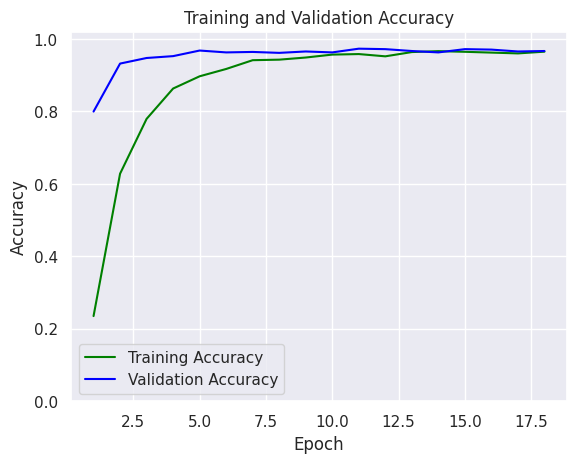

In [62]:
#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim(0,1.02)
plt.show()

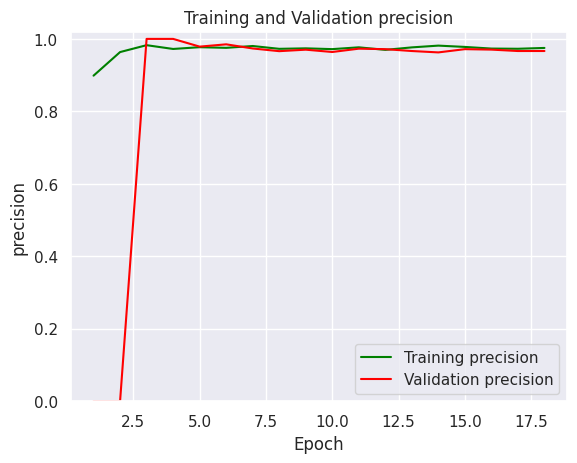

In [63]:
plt.figure()
#precision plot
plt.plot(epochs, precision, color='green', label='Training precision')
plt.plot(epochs, val_precision, color='red', label='Validation precision')
plt.title('Training and Validation precision')
plt.xlabel('Epoch')
plt.ylabel('precision')
plt.legend()
plt.ylim(0,1.02)
plt.show()

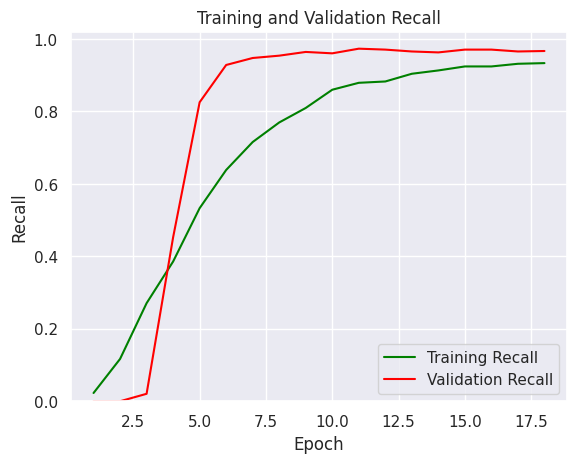

In [64]:
plt.figure()
#Recall plot
plt.plot(epochs, recall, color='green', label='Training Recall')
plt.plot(epochs, val_recall, color='red', label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.ylim(0,1.02)
plt.show()

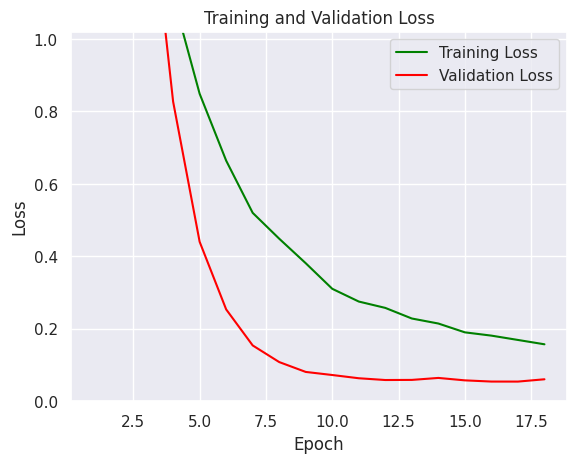

In [65]:
plt.figure()
#loss plot
plt.plot(epochs, loss, color='green', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0,1.02)
plt.show()

In [66]:
#evaluate model
evaluate_model(efficientnet_model, train_dataset, valid_dataset, test_dataset)

86/86 ━━━━━━━━━━━━━━━━━━━━ 49s 322ms/step - accuracy: 0.9727 - loss: 0.0551 - precision: 0.9742 - recall: 0.9726
Training Data:
Loss:       0.05024994537234306
Accuracy:   0.9757620096206665
Precision:  0.9775487780570984
Recall:     0.9753947854042053
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 465ms/step - accuracy: 0.9739 - loss: 0.0616 - precision: 0.9739 - recall: 0.9739

Validation Data:
Loss:       0.06346601247787476
Accuracy:   0.9730077385902405
Precision:  0.9730077385902405
Recall:     0.9730077385902405
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 961ms/step - accuracy: 0.9636 - loss: 0.0550 - precision: 0.9639 - recall: 0.9636

Test Data:
Loss:       0.05014140158891678
Accuracy:   0.9691516757011414
Precision:  0.9716494679450989
Recall:     0.9691516757011414


(0.05, 0.06, 0.05, 0.98, 0.97, 0.97, 0.98, 0.97, 0.97, 0.98, 0.97, 0.97)

In [67]:
efficientnet_model.save('efficientnet_model.h5')

In [68]:
Final_report.append(evaluate_model(efficientnet_model, train_dataset, valid_dataset, test_dataset))

86/86 ━━━━━━━━━━━━━━━━━━━━ 19s 220ms/step - accuracy: 0.9727 - loss: 0.0551 - precision: 0.9742 - recall: 0.9726
Training Data:
Loss:       0.05024994537234306
Accuracy:   0.9757620096206665
Precision:  0.9775487780570984
Recall:     0.9753947854042053
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 220ms/step - accuracy: 0.9739 - loss: 0.0616 - precision: 0.9739 - recall: 0.9739

Validation Data:
Loss:       0.06346601247787476
Accuracy:   0.9730077385902405
Precision:  0.9730077385902405
Recall:     0.9730077385902405
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - accuracy: 0.9636 - loss: 0.0550 - precision: 0.9639 - recall: 0.9636

Test Data:
Loss:       0.05014140158891678
Accuracy:   0.9691516757011414
Precision:  0.9716494679450989
Recall:     0.9691516757011414


## DenseNet

In [69]:
input_shape = (224, 224, 3)  
# Define inputs
inputs = tf.keras.Input(shape=input_shape)
print(inputs)
model_name='DenseNet121'

base_model = models[model_name](include_top=False, weights='imagenet', input_tensor=inputs)

<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=None, name=keras_tensor_1026>
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [70]:
def DenseNet(base_model, inputs):
    # Freeze the base model layers
    base_model.trainable = False

    x = tf.keras.layers.Flatten()(base_model.output)

    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(95, activation='softmax')(x)

    # Create model
    model = tf.keras.models.Model(inputs = inputs, outputs = outputs)
    return model

In [71]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_recall', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

callbacks = [early_stopping, model_checkpoint]
metrics=['accuracy', 'precision', 'recall']
# Create the model

In [72]:
densenet_model = DenseNet(base_model, inputs)
densenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics= metrics)

In [73]:
#densenet_model.summary()

In [74]:
history = densenet_model.fit(
    train_images,train_labels,
    epochs=25,
    batch_size=64,
    validation_data=(valid_images,valid_labels),
    validation_batch_size=64,
    #callbacks=callbacks
)

Epoch 1/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 76s 989ms/step - accuracy: 0.0343 - loss: 4.9380 - precision: 0.1783 - recall: 0.0053 - val_accuracy: 0.0810 - val_loss: 5.9738 - val_precision: 0.3306 - val_recall: 0.0514
Epoch 2/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 193ms/step - accuracy: 0.1897 - loss: 3.4331 - precision: 0.6418 - recall: 0.0340 - val_accuracy: 0.2147 - val_loss: 3.5551 - val_precision: 0.7188 - val_recall: 0.0887
Epoch 3/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 174ms/step - accuracy: 0.3604 - loss: 2.6782 - precision: 0.8177 - recall: 0.0951 - val_accuracy: 0.3997 - val_loss: 2.5104 - val_precision: 0.9542 - val_recall: 0.1607
Epoch 4/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - accuracy: 0.4686 - loss: 2.1611 - precision: 0.8528 - recall: 0.1467 - val_accuracy: 0.5308 - val_loss: 1.8115 - val_precision: 0.9324 - val_recall: 0.2481
Epoch 5/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 174ms/step - accuracy: 0.5507 - loss: 1.7917 - precision: 0.8818 - recall: 0.2199 - val_accuracy: 0.6555 - val_loss: 1

In [75]:
#plotting training values
import seaborn as sns
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

precision = history.history['precision']
val_precision = history.history['val_precision']

recall =history.history['recall']
val_recall =history.history['val_recall']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

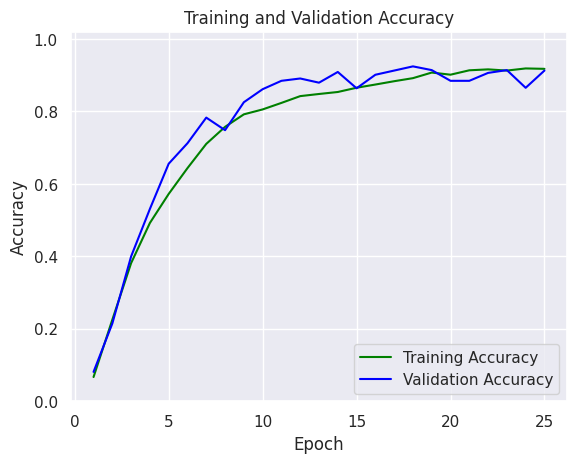

In [76]:
#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim(0,1.02)
plt.show()

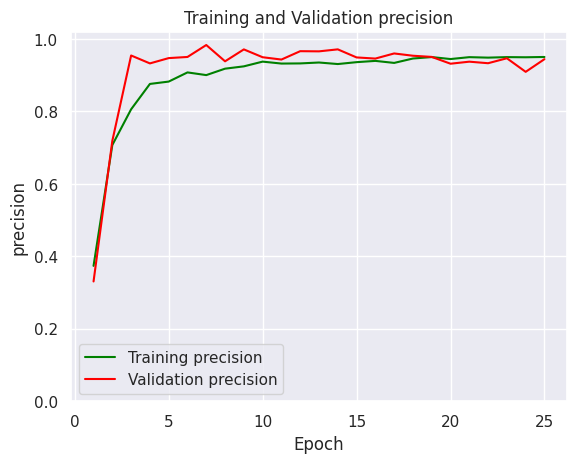

In [77]:
plt.figure()
#precision plot
plt.plot(epochs, precision, color='green', label='Training precision')
plt.plot(epochs, val_precision, color='red', label='Validation precision')
plt.title('Training and Validation precision')
plt.xlabel('Epoch')
plt.ylabel('precision')
plt.legend()
plt.ylim(0,1.02)
plt.show()

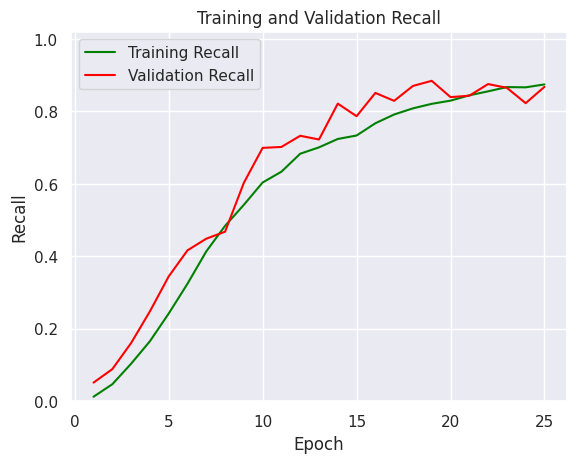

In [78]:
plt.figure()
#Recall plot
plt.plot(epochs, recall, color='green', label='Training Recall')
plt.plot(epochs, val_recall, color='red', label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.ylim(0,1.02)
plt.show()

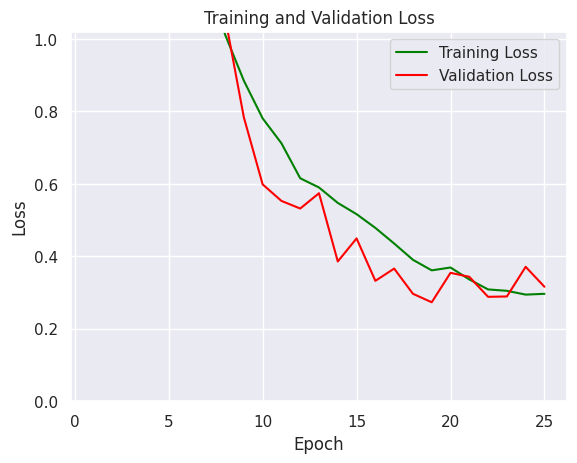

In [79]:
plt.figure()
#loss plot
plt.plot(epochs, loss, color='green', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0,1.02)
plt.show()

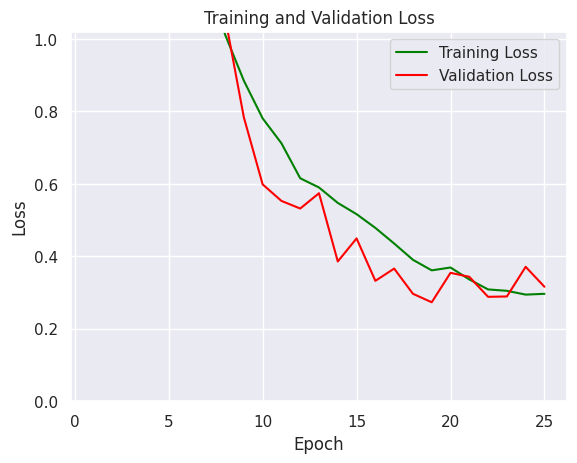

In [80]:
plt.figure()
#loss plot
plt.plot(epochs, loss, color='green', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0,1.02)
plt.show()

In [81]:
#evaluate model
evaluate_model(densenet_model, train_dataset, valid_dataset, test_dataset)

86/86 ━━━━━━━━━━━━━━━━━━━━ 29s 159ms/step - accuracy: 0.9450 - loss: 0.2031 - precision: 0.9648 - recall: 0.9057
Training Data:
Loss:       0.20978613197803497
Accuracy:   0.9449136853218079
Precision:  0.9690074324607849
Recall:     0.9070877432823181
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 259ms/step - accuracy: 0.9095 - loss: 0.3137 - precision: 0.9363 - recall: 0.8738

Validation Data:
Loss:       0.3159686028957367
Accuracy:   0.9125964045524597
Precision:  0.9440559148788452
Recall:     0.8676092624664307
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 700ms/step - accuracy: 0.8961 - loss: 0.3004 - precision: 0.9283 - recall: 0.8553

Test Data:
Loss:       0.3200320303440094
Accuracy:   0.897172212600708
Precision:  0.9436619877815247
Recall:     0.8611825108528137


(0.21, 0.32, 0.32, 0.94, 0.91, 0.9, 0.97, 0.94, 0.94, 0.91, 0.87, 0.86)

In [82]:
densenet_model.save('densenet_model.h5')

In [83]:
Final_report.append(evaluate_model(densenet_model, train_dataset, valid_dataset, test_dataset))

86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.9450 - loss: 0.2031 - precision: 0.9648 - recall: 0.9057
Training Data:
Loss:       0.20978613197803497
Accuracy:   0.9449136853218079
Precision:  0.9690074324607849
Recall:     0.9070877432823181
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9095 - loss: 0.3137 - precision: 0.9363 - recall: 0.8738

Validation Data:
Loss:       0.3159686028957367
Accuracy:   0.9125964045524597
Precision:  0.9440559148788452
Recall:     0.8676092624664307
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.8961 - loss: 0.3004 - precision: 0.9283 - recall: 0.8553

Test Data:
Loss:       0.3200320303440094
Accuracy:   0.897172212600708
Precision:  0.9436619877815247
Recall:     0.8611825108528137


# Final Insights

In [92]:
Model_Accuracy = pd.DataFrame(
    Final_report,
    index=['Normal CNN',"VGG19",'EfficientNet','densenet_model'],
    columns=[
        'Train Loss', 'Validation Loss', 'Test Loss',
        'Train Accuracy', 'Validation Accuracy', 'Test Accuracy',
        'Train Precision', 'Validation Precision', 'Test Precision',
        'Train Recall', 'Validation Recall', 'Test Recall'
    ]
)

In [93]:
Model_Accuracy

Train Loss  Validation Loss  Test Loss  Train Accuracy  \
Normal CNN            0.04             0.33       0.27            0.99   
VGG19                 0.04             0.06       0.06            0.98   
EfficientNet          0.05             0.06       0.05            0.98   
densenet_model        0.21             0.32       0.32            0.94   

                Validation Accuracy  Test Accuracy  Train Precision  \
Normal CNN                     0.92           0.93             0.99   
VGG19                          0.97           0.98             0.99   
EfficientNet                   0.97           0.97             0.98   
densenet_model                 0.91           0.90             0.97   

                Validation Precision  Test Precision  Train Recall  \
Normal CNN                      0.92            0.94          0.99   
VGG19                           0.97            0.98          0.98   
EfficientNet                    0.97            0.97          0.98   
densenet_model                  0.94            0.94          0.91   

                Validation Recall  Test Recall  
Normal CNN                   0.91         0.93  
VGG19                        0.97         0.98  
EfficientNet                 0.97         0.97  
densenet_model               0.87         0.86

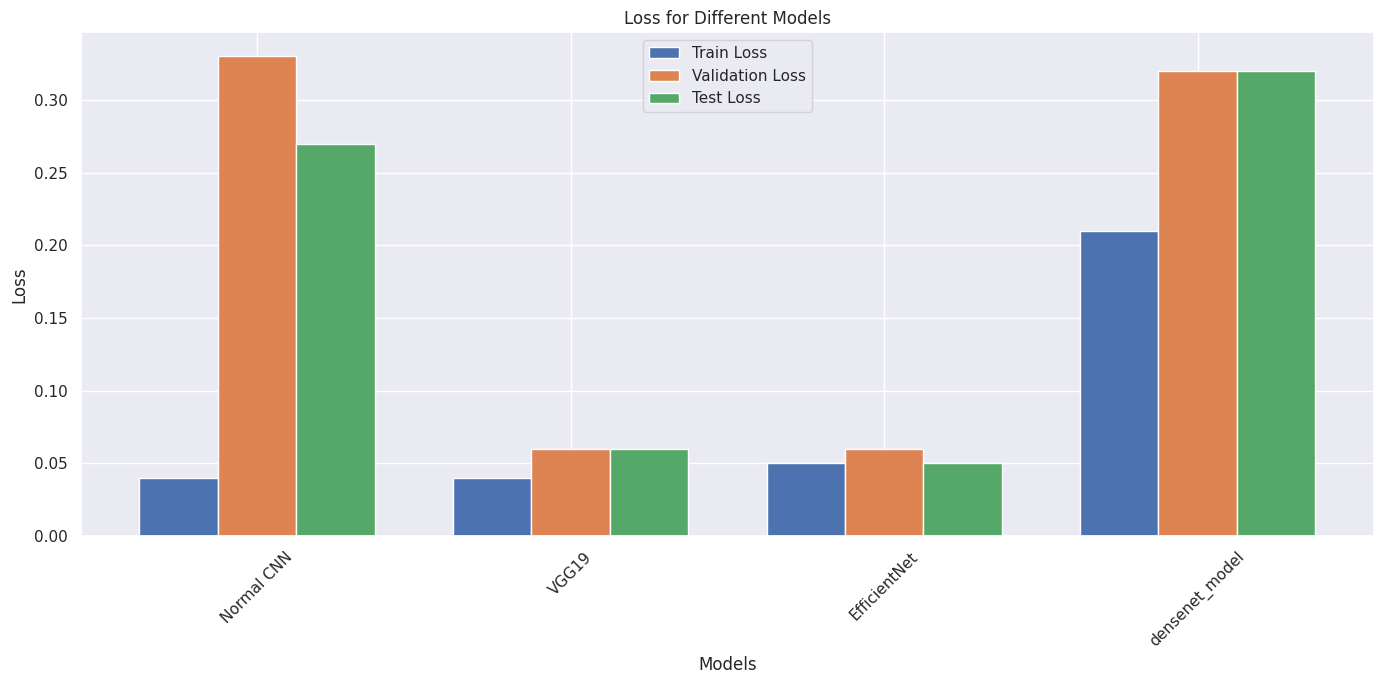

In [94]:
plt.figure(figsize=(14, 7))
bar_width = 0.25  # Width of the bars
index = np.arange(len(Model_Accuracy.index))  # Indices for x-axis

plt.bar(index, Model_Accuracy['Train Loss'], width=bar_width, label='Train Loss')
plt.bar(index + bar_width, Model_Accuracy['Validation Loss'], width=bar_width, label='Validation Loss')
plt.bar(index + 2 * bar_width, Model_Accuracy['Test Loss'], width=bar_width, label='Test Loss')

plt.title('Loss for Different Models')
plt.xlabel('Models')
plt.ylabel('Loss')
plt.xticks(index + bar_width, Model_Accuracy.index, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

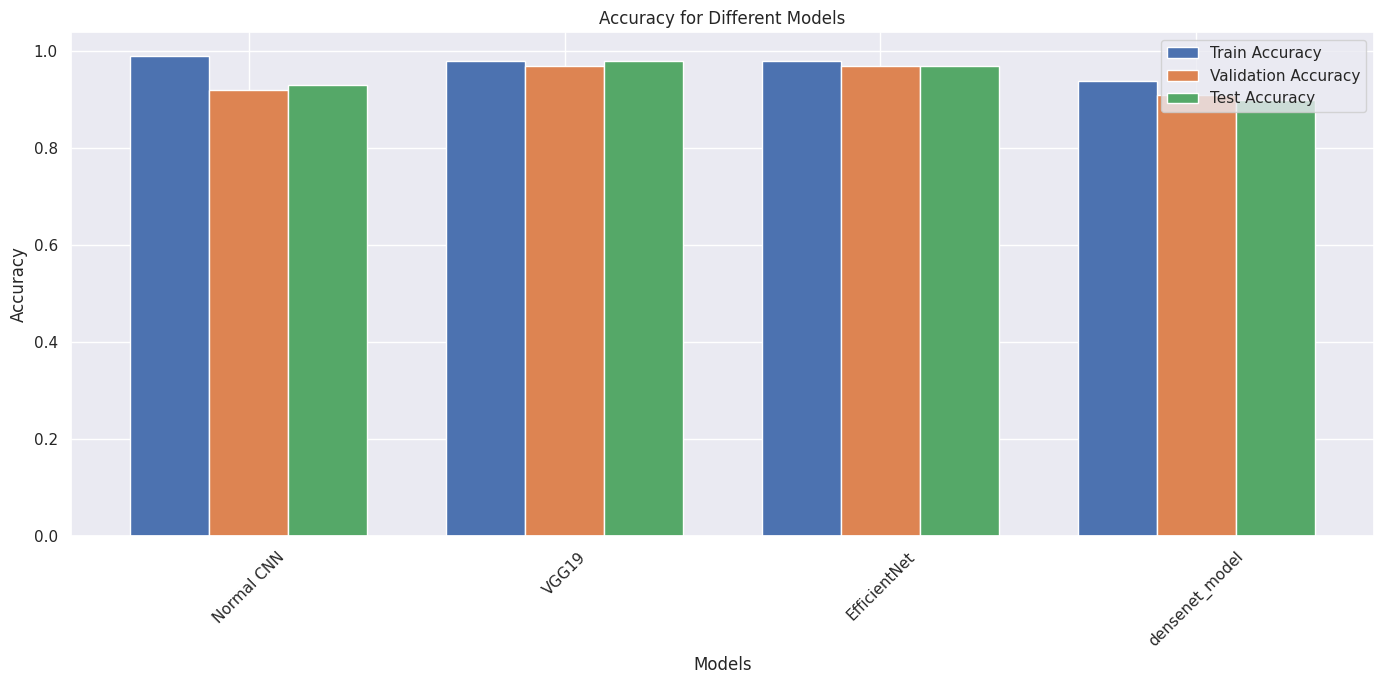

In [95]:
plt.figure(figsize=(14, 7))
plt.bar(index, Model_Accuracy['Train Accuracy'], width=bar_width, label='Train Accuracy')
plt.bar(index + bar_width, Model_Accuracy['Validation Accuracy'], width=bar_width, label='Validation Accuracy')
plt.bar(index + 2 * bar_width, Model_Accuracy['Test Accuracy'], width=bar_width, label='Test Accuracy')

plt.title('Accuracy for Different Models')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(index + bar_width, Model_Accuracy.index, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

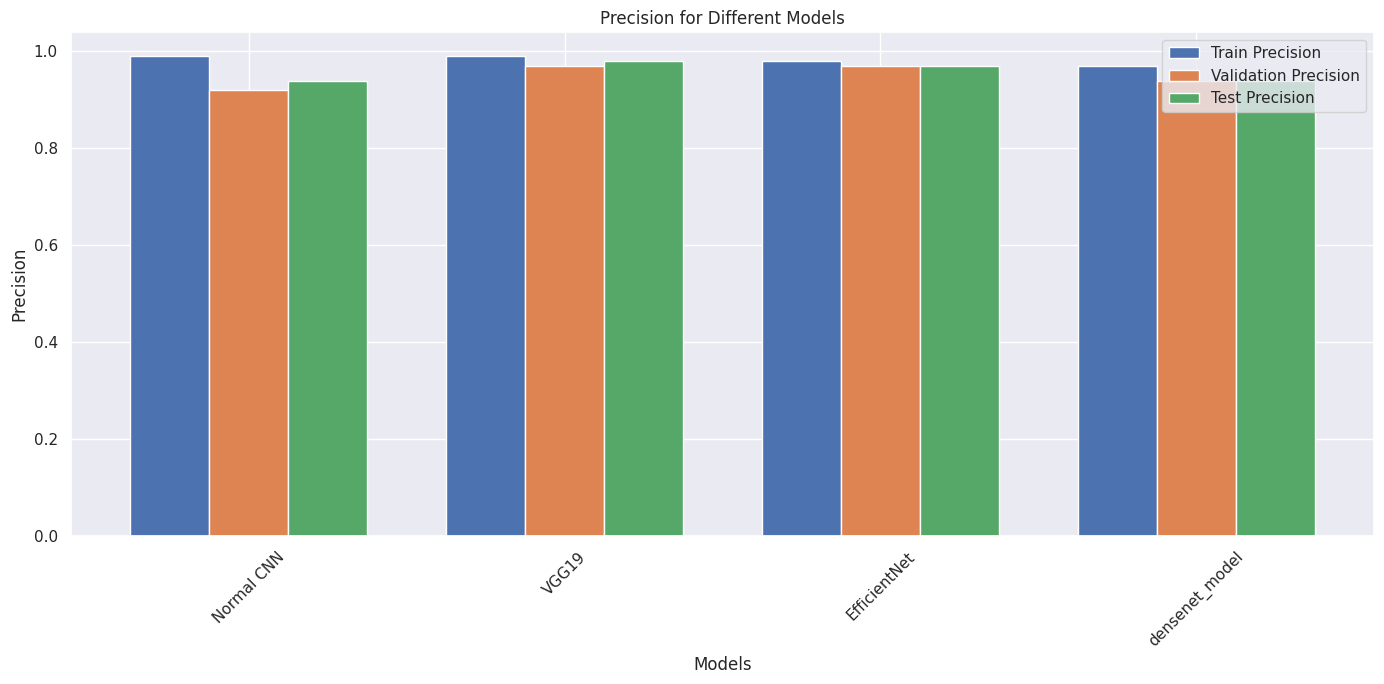

In [96]:
plt.figure(figsize=(14, 7))
plt.bar(index, Model_Accuracy['Train Precision'], width=bar_width, label='Train Precision')
plt.bar(index + bar_width, Model_Accuracy['Validation Precision'], width=bar_width, label='Validation Precision')
plt.bar(index + 2 * bar_width, Model_Accuracy['Test Precision'], width=bar_width, label='Test Precision')

plt.title('Precision for Different Models')
plt.xlabel('Models')
plt.ylabel('Precision')
plt.xticks(index + bar_width, Model_Accuracy.index, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

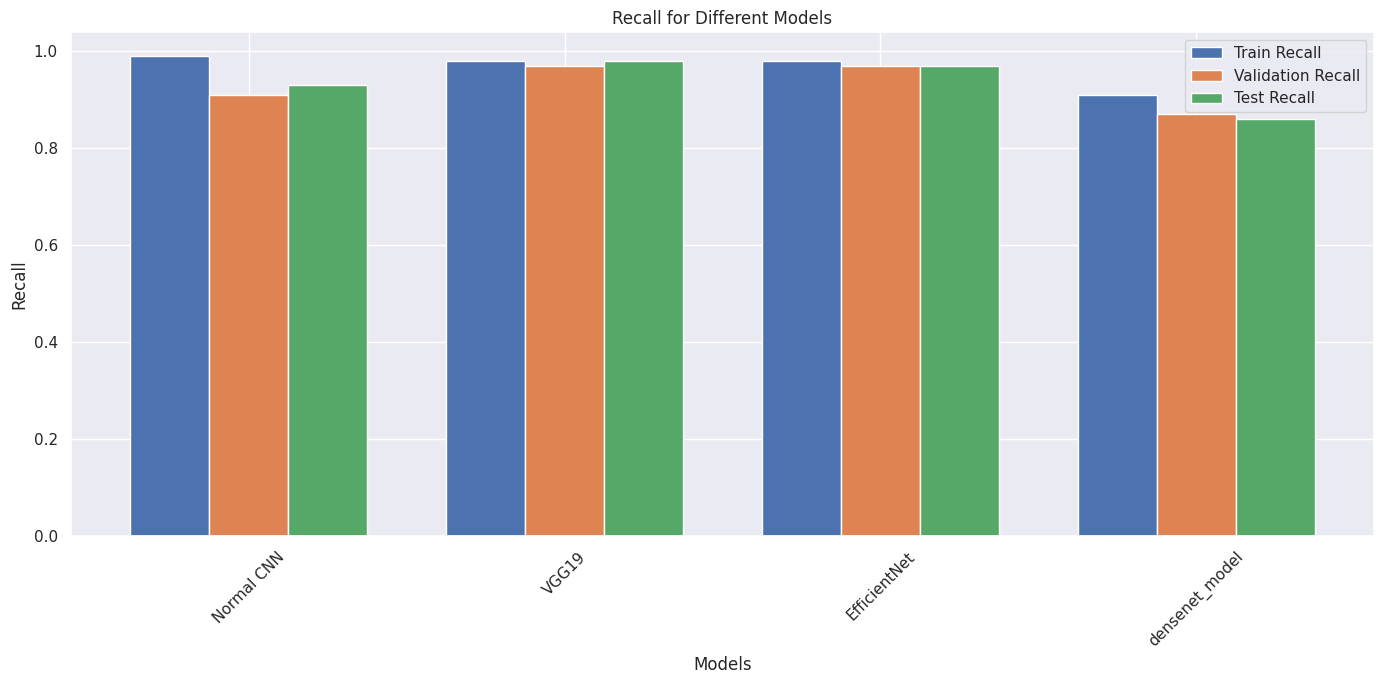

In [97]:
plt.figure(figsize=(14, 7))
plt.bar(index, Model_Accuracy['Train Recall'], width=bar_width, label='Train Recall')
plt.bar(index + bar_width, Model_Accuracy['Validation Recall'], width=bar_width, label='Validation Recall')
plt.bar(index + 2 * bar_width, Model_Accuracy['Test Recall'], width=bar_width, label='Test Recall')

plt.title('Recall for Different Models')
plt.xlabel('Models')
plt.ylabel('Recall')
plt.xticks(index + bar_width, Model_Accuracy.index, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [99]:
Model_Accuracy

Train Loss  Validation Loss  Test Loss  Train Accuracy  \
Normal CNN            0.04             0.33       0.27            0.99   
VGG19                 0.04             0.06       0.06            0.98   
EfficientNet          0.05             0.06       0.05            0.98   
densenet_model        0.21             0.32       0.32            0.94   

                Validation Accuracy  Test Accuracy  Train Precision  \
Normal CNN                     0.92           0.93             0.99   
VGG19                          0.97           0.98             0.99   
EfficientNet                   0.97           0.97             0.98   
densenet_model                 0.91           0.90             0.97   

                Validation Precision  Test Precision  Train Recall  \
Normal CNN                      0.92            0.94          0.99   
VGG19                           0.97            0.98          0.98   
EfficientNet                    0.97            0.97          0.98   
densenet_model                  0.94            0.94          0.91   

                Validation Recall  Test Recall  
Normal CNN                   0.91         0.93  
VGG19                        0.97         0.98  
EfficientNet                 0.97         0.97  
densenet_model               0.87         0.86

In [98]:
Model_Accuracy.to_csv('report.csv', index = True)